# ARIMA

No confidence intervals


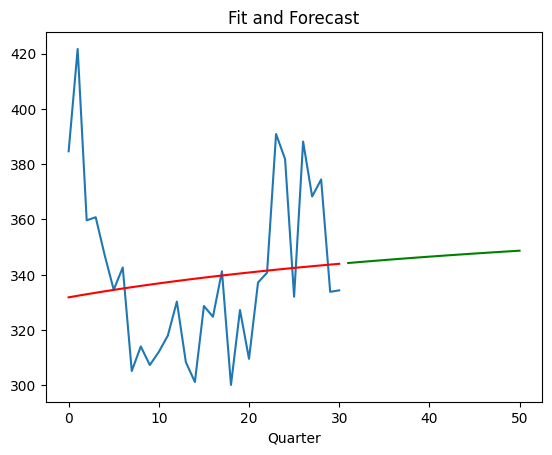

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import linregress


# fit model
class prediction():

    def __init__(self):
        return


    # "In reality, you want to conduct time series cross-validation to select the best model" (params)
    
    def fit_arima(self, data, params=(10,1,1), steps=20):
        '''
            GIVES WAY TOO HIGH ERRORS, NOT VIABLE
            give 1 areas quarterly data 

            returns
            fit 
            forecast = prediction of i steps
            errors
        '''
        raise(ReferenceError("Don't use fit_arima not suitable for our data"))
        series = pd.Series(data)
        self.data = data
        self.params = params
        self.steps = steps
        

        model = ARIMA(series, order=params, trend='t') 
        fit_model = model.fit()
        forecast = fit_model.get_forecast(steps=steps) # statsmodels obj

        # results
        self.prediction = forecast.predicted_mean
        self.fit = fit_model.fittedvalues
        self.ci = forecast.conf_int()

        return self.fit, self.prediction, self.ci
    
    def fit_slope(self, data, steps=20):
        ''' same format as arima; no errors'''
        self.data = data
        self.params = None
        self.steps = steps

        slope, intercept, _, _, _ = linregress(np.arange(len(data)), data)
        self.fit = slope * np.arange(len(data)) + intercept
        self.prediction = slope * np.arange(len(data), len(data) + steps) + intercept
        
        return self.fit, self.prediction
    
    def plot(self):
        idxs = range(len(self.data))
        forecast_idxs = pd.RangeIndex(start=len(idxs), stop=len(idxs) + self.steps)

        # data and fit with predictions
        plt.plot(idxs, self.data, label='Data')
        plt.plot(idxs, self.fit, color='red', label='Fit')
        plt.plot(forecast_idxs, self.prediction, color='green', label=f'Forecast ({self.steps} steps)')

        # confidence intervals 
        try:
            ci = self.ci
            plt.fill_between(forecast_idxs, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
        except:
            print('No confidence intervals')

        # legend
        plt.xlabel('Quarter')
        # plt.ylabel('')
        plt.title('Fit and Forecast')
        # plt.legend()

        plt.show()
        return 
    

    def fit_diff(self, data_price, data_rent, model='slope', steps=20):
        ''' fits to both and calc diff
            diff = price/rent
            return:
            3 tuples for diff, price, rent (fit, prediction)
        '''

        if model=='slope':
            fit_price, pred_price = self.fit_slope(data_price, steps=steps)
            # self.plot()
            fit_rent, pred_rent = self.fit_slope(data_rent, steps=steps)
            # self.plot()

            self.data = np.divide(data_price, data_rent)
            self.fit = fit_price/fit_rent
            self.prediction = np.divide(pred_price, pred_rent)
            return (self.fit, self.prediction), (fit_price, pred_price), (fit_rent, pred_rent)
        else:
            raise('use model slope for prediction.fit_diff()')
        
    def write_csv(self, data, steps=20):
        # only writes yksiöt
        df_pred = pd.DataFrame()
        for posti in data.loc[(data['Huoneluku']=='Yksiöt')]['Posti'].unique():
            for huoneluku in ['Yksiöt', 'Kaksiot', 'Kolmiot+']:
                data_1Q_price = data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Neliöhinta (EUR/m2)']    #['Neliövuokra (eur/m2)']
                data_1Q_rent = data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Neliövuokra (eur/m2)'] 
                if data_1Q_price.empty or data_1Q_rent.empty:
                    # skips when there is no data for 'huoneluku'
                    # print('TRYHJÄÄÄ:',posti, huoneluku, data_1Q_price.empty, data_1Q_rent.empty)
                    continue
                
                # calc predicted Qs
                Q_last = data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Vuosineljännes'].iloc[-1]
                Qs = pd.period_range(Q_last, periods=steps+1, freq='Q')[1:].strftime('%YQ%q')

                diff, price, rent = self.fit_diff(data_1Q_price, data_1Q_rent, steps=steps)
                l = len(diff[1])
                df_posti = pd.DataFrame({'Vuosineljännes': Qs,
                            'Huoneluku': [huoneluku]*l,
                            'Neliöhinta (EUR/m2)': np.around(price[1], 2),
                            'Lukumäärä_x': ['.']*l,
                            'Posti': [posti]*l,
                            'Kaupunginosa_x': [data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Kaupunginosa_x'].iloc[0]]*l,
                            'Kaupunki': [data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Kaupunki'].iloc[0]]*l,
                            'Lukumäärä_y': ['.']*l,
                            'Neliövuokra (eur/m2)': np.around(rent[1], 2),
                            'Kaupunginosa_y': [data.loc[(data['Huoneluku']==huoneluku) & (data['Posti']==posti)]['Kaupunginosa_y'].iloc[0]]*l,
                            'difference': np.around(diff[1], 2)})
                
                df_pred = pd.concat([df_pred, df_posti], ignore_index=True)
        df_pred.to_csv('prediction_data.csv')
        return


data=pd.read_csv("merged_data.csv", dtype={'Posti': str})
a = prediction()
# data_1Q_price = data.loc[(data['Huoneluku']=='Yksiöt') & (data['Posti']==140)]['Neliöhinta (EUR/m2)']
# data_1Q_rent = data.loc[(data['Huoneluku']=='Yksiöt') & (data['Posti']==140)]['Neliövuokra (eur/m2)'] 
# a.fit_arima(data_1Q)
# a.fit_slope(data_1Q)
# a.fit_diff(data_1Q_price, data_1Q_rent)
# print(data.loc[(data['Huoneluku']=='Yksiöt') & (data['Posti']==240)]['Neliöhinta (EUR/m2)'])
a.write_csv(data)
a.plot()

